# Topic Modeling with LDA

## Importing libraries and data

In [2]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn --upgrade
!pip install deepcut

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 28.9 MB/s eta 0:00:00


In [465]:
import pythainlp
import gensim

import numpy as np
import pandas as pd
import re
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections
import deepcut

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [466]:
# Wongnai review comment ครกไม้ไทยลาว (Krok Mai Thai Lao) restaurant
data = {'comment':
        ['ได้รับสินค้าแล้วค่ะทางร้านส่งเร็ว แพ็คมาดีของมาถึงไม่มีอะไรเสียหาย กลิ่นนี้หอมมากๆเคยซื้อตัวเทสมาแล้วชอบเลยมาสั่งขวดใหญ่ ช่วงที่สั่งมีโค้ดลดเหลือแค่280กว่าบาทเอง ได้สเปรย์แอลกอฮอล์แถมมาด้วย ขอบคุณมากค่ะ แล้วส่วนตัวชอบกลิ่นควันไม้กฤษณาอีกกลิ่น ไว้จะมาตำขวด10mlอีก',
        'หอมมาก ติดทนมากกก ฉีด7.00 เลิกงาน 17.00 ยังหอมอยู่เลย เดินไปไหนก็มีแต่คนทัก ว่าหอมจัง ปล. กลิ่นที่ใช้ พลับพลึงแพร์ ค่ะ',
        'จัดส่งรวดเร็วสินค้ามีคุณภาพดีกลิ่นติดทนราคาดี package แข็งแรงกลิ่นหอมน่าใช้ติดทนทั้งวันโดยรวมชอบมากๆ',
        'หอมมาก ต้องลอง กลิ่นกฤษณาไม้กำยาน หอมมาก',
        'ส่งไวมากค่ะ ได้มาในราคาช้อปปี้ไลฟ์ คุ้มสุดๆ อยากจะซื้อมาลองทุกกลิ่น 555 มีแถมเป็นหลอดจิ๋วให้ด้วย กลิ่นมะลิสุดๆไปเลย ส่วน 2 ขวดใหญ่เป็นกลิ่นที่ใช้ประจำอยู่แล้วค่ะ',
        'ใช้ครั้งแรกหลงรัก ติดใจ หอมละมุนมาก',
        'ร้านส่งให้เร็วมากกกรอวันเดียวได้ของ ห่อมาดีแพคเกจสวย',
        'น้ำหอมกลิ่นดีงามหอมข้ามวัน แนะนำเลยดีงามทุกกลิ่นคุณภาพทุกขวด',
        'เสียดายกลิ่นจาง  2-3ชั่วโมงกลิ่นก็จางแล้วค่ะ',
        'ได้รับสินค้าแล้วค่ะทางร้านส่งเร็ว แพ็คมาดีของมาถึงไม่มีอะไรเสียหาย',
        'ตั้งแต่เปลี่ยนแพคเกจใหม่ อัพราคา มีความรู้สึกว่า กลิ่นจางมาก แถมติดไม่ทนเหมือนรุ่นก่อน ๆ เลยค่ะ มีการปรับสูตรไหมคะ มีคนคอมเม้นท์หลายคนอยู่นะคะเรื่องนี้',
        'อยากให้ปรับปรุงเรื่องความติดทนหน่อยค่ะเมื่อก่อนใช้คือหอมติดเสื้อผ้านานมาก พักหลังไม่ถึง 2 ชม.กลิ่นจางแล้วค่ะ ปรับราคาเพิ่มขึ้นแต่คุณภาพไม่ควรลดลงนะคะ',
        'กลิ่นนี้หอมดีค่ะ เคยลองสั่งซื้อแบบขวดเล็กๆมาใช้ จึงได้ซื้อขวดใหญ่ และซื้อตอนลดราคา แถมใช้เหรียญลดอีก ก็เลยได้ในราคาที่ถูก ส่งสินค้ารวดเร็วดีค่ะ',
        'สินค้าแพ็คมาดี ส่งถึงเร็วค่ะ ใช้กลิ่นนี้ประจำ คิดว่าเหมาะกับตัวเองที่สุดแล้ว เดินผ่านใครก็ถาม เพราะกลิ่นหอมมาก ราคาไม่แพง คนไทยผลิตเองด้วยค่ะ',
        'เดี๋ยวนี้กลิ่นจางค่ะอยากให้กลับมากลิ่นติดทนเหมือนเมื่อก่อนอีกค่ะ',
        'จัดส่งเร็วมากๆๆๆ ค่ะวันเดียวเองได้รับสินค้าแล้ว',
        'แพ็คเกตแน่นหนาดีสินค้าไม่เสียหาย จัดส่งรวดเร็ว ขอบคุณสำหรับกลิ่นเขอรี่ที่แถมมา',
        'สั่งซื้อจากไลฟ์ ใช้โค้ดลด 50% คุ้มค่ามากๆ ร้านค้าจัดส่งไว จัดส่งวันถัดไปหลังจากไลฟ์เลย EMS ถึงไวด้วย ประทับใจ กลิ่นดอกส้มบวกดอกไม้ขาว หวานใส กลิ่น unisex โปร่งกังวานและสะอาด น่าอยู่ใกล้',
        'น้ำหอมหอม และติดทนมากๆค่ะ ฉีดแล้วรู้สึกเป็นผู้หญิงน่ารัก สดใสร่าเริงมองโลกในแง่บวก ครั้งหน้าต้องซื้อขวดใหญ่แน่นอนค่ะ',
        'ไม่ผิดหวังเลยค่ะ เลิฟสุดๆ ใช้โค้ดได้ส่วนลด 100 บาท คุ้มมากค่ะ '
        ]}

df = pd.DataFrame(data)
df.head()

,comment
0,ได้รับสินค้าแล้วค่ะทางร้านส่งเร็ว แพ็คมาดีของม...
1,หอมมาก ติดทนมากกก ฉีด7.00 เลิกงาน 17.00 ยังหอม...
2,จัดส่งรวดเร็วสินค้ามีคุณภาพดีกลิ่นติดทนราคาดี ...
3,หอมมาก ต้องลอง กลิ่นกฤษณาไม้กำยาน หอมมาก
4,ส่งไวมากค่ะ ได้มาในราคาช้อปปี้ไลฟ์ คุ้มสุดๆ อย...


## Tokenize Words with pythainlp

In [467]:
stop_word = list(pythainlp.corpus.thai_stopwords())
rm_word = ['',' ','    ','\n', '(', ')', '?', '+', '--', '//', '\u200b', 'ๆ(', '..', 'ๆๆๆๆ', 'ๆ', 'นะคะ', '-', '!', "['", "','", "'", ',', '[']
screenword = stop_word + rm_word

def tokenize_n_space(sentence):
    merged = ''
    words = pythainlp.word_tokenize( str(sentence), engine = 'deepcut')
    for i in words :
        if i not in screenword :
            merged = merged + ',' + i
    return merged[1:]

In [468]:
df['tokenized'] = df['comment'].apply(lambda x: tokenize_n_space(x))
df.tail()

2/2 [==============================] - 0s 15ms/step


,comment,tokenized
15,จัดส่งเร็วมากๆๆๆ ค่ะวันเดียวเองได้รับสินค้าแล้ว,สินค้า
16,แพ็คเกตแน่นหนาดีสินค้าไม่เสียหาย จัดส่งรวดเร็ว...,"แพ็คเกต,แน่นหนา,ดี,สินค้า,เสียหาย,ขอบคุณ,สำหรั..."
17,สั่งซื้อจากไลฟ์ ใช้โค้ดลด 50% คุ้มค่ามากๆ ร้าน...,"สั่ง,ซื้อ,ไลฟ์,โค้ด,ลด,50,%,คุ้มค่า,ร้าน,ค้า,ไ..."
18,น้ำหอมหอม และติดทนมากๆค่ะ ฉีดแล้วรู้สึกเป็นผู้...,"น้ำ,หอม,หอม,ติดทน,ฉีด,รู้สึก,หญิง,รัก,สดใส,ร่า..."
19,ไม่ผิดหวังเลยค่ะ เลิฟสุดๆ ใช้โค้ดได้ส่วนลด 100...,"หวัง,เลิฟ,โค้ด,ลด,100,บาท,คุ้ม"


In [469]:
doc = df['tokenized'].to_list()
texts = [ [i for i in dc.split(',')] for dc in doc ]
dictionary = gensim.corpora.Dictionary(texts)

print(dictionary.token2id.keys())

dict_keys(['10', '280', 'ml', 'กฤษณา', 'กลิ่น', 'ขวด', 'ขอบคุณ', 'ควัน', 'ชอบ', 'ซื้อ', 'ดี', 'ตัว', 'ตำ', 'บาท', 'ร้าน', 'ลด', 'สั่ง', 'สินค้า', 'สเปรย์', 'ส่งเร็ว', 'หอม', 'เทส', 'เสียหาย', 'แถม', 'แพ็คมา', 'แอลกอฮอล์', 'โค้ด', 'ไม้', '17.00', '7.00', 'กก', 'คน', 'งาน', 'ฉีด', 'ติดทน', 'ทัก', 'ปล.', 'พลับพลึงแพร์', 'หอมจัง', 'เดิน', 'เลิก', 'package', 'คุณภาพ', 'ติด', 'ทน', 'ราคา', 'แข็งแรง', 'กำยาน', 'ลอง', '2', '555', 'คุ้ม', 'จิ๋ว', 'ช้อปปี้ไลฟ์', 'ประจำ', 'มะลิ', 'หลอด', 'อยู่แล้ว', 'ไว', 'ติดใจ', 'ละมุน', 'หลงรัก', 'ก', 'กกรอ', 'ดีแพคเกจสวย', 'ห่อ', 'ข้าม', 'งาม', 'ดีงาม', 'น้ำ', 'แนะนำ', '3', 'จาง', 'ชั่วโมง', 'เสียดาย', 'คอมเม้นท์', 'รุ่น', 'รู้สึก', 'สูตร', 'อัพราคา', 'เปลี่ยนแพคเกจ', 'เรื่อง', 'เหมือน', 'ไหม', 'ชม.', 'ปรับปรุง', 'พัก', 'เสื้อผ้า', 'ตอน', 'เหรียญ', 'ถาม', 'ผลิต', 'เหมาะ', 'แพง', 'ไทย', 'เดี๋ยวนี้', 'รี่', 'สำหรับ', 'เขอ', 'แน่นหนา', 'แพ็คเกต', '%', '50', 'EMS', 'unisex', 'กังวาน', 'ขาว', 'คุ้มค่า', 'ค้า', 'ดอก', 'ถัด', 'ประทับใจ', 'สะอาด', 'ส้มบวก', 'หวาน', '

In [470]:
gensim_corpus = [ dictionary.doc2bow(tx, allow_update = True) for tx in texts ]
word_frq = [ [ (dictionary[ides], frq) for ides, frq in coup ] for coup in gensim_corpus ]

## Topic Modeling using LDA

In [471]:
num_topic = 3
chunksize = 4000 # size of the doc looked at every pass
passes = 20 # number of passes through documents
iterations = 50
eval_number = 1 # more number, more compute time spending

# Make index to word dictionary
temp = dictionary[0]
id2word = dictionary.id2token

%time
model = gensim.models.LdaModel( corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto'
                               , iterations=iterations, num_topics=num_topic, passes=passes, eval_every=eval_number )

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


### Predict Topics

In [472]:
model.show_topic(0)

[('กลิ่น', 0.0809889),
 ('ดี', 0.046929643),
 ('หอม', 0.036960818),
 ('สินค้า', 0.0368014),
 ('ขวด', 0.031914808),
 ('ราคา', 0.03191262),
 ('ซื้อ', 0.026875453),
 ('แถม', 0.026589502),
 ('ลด', 0.021835912),
 ('ติด', 0.0167976)]

In [473]:
model.show_topic(1)

[('หอม', 0.03694317),
 ('กลิ่น', 0.028743116),
 ('จาง', 0.025866779),
 ('โค้ด', 0.01478386),
 ('ร้าน', 0.014783348),
 ('ลด', 0.014782548),
 ('บาท', 0.014781533),
 ('ชั่วโมง', 0.014781136),
 ('หวัง', 0.014781133),
 ('3', 0.014781124)]

In [474]:
model.show_topic(2)

[('กลิ่น', 0.0618998),
 ('หอม', 0.04233457),
 ('ไว', 0.022826726),
 ('ไลฟ์', 0.022796419),
 ('ดอก', 0.022795405),
 ('ไม้', 0.022795085),
 ('ลอง', 0.013036551),
 ('ซื้อ', 0.013031912),
 ('ฉีด', 0.013027523),
 ('พลับพลึงแพร์', 0.013027508)]

In [475]:
df['topics'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][0])
df['score'] = df['tokenized'].apply(lambda x: model.get_document_topics(dictionary.doc2bow(x.split(',')))[0][1])
df

,comment,tokenized,topics,score
0,ได้รับสินค้าแล้วค่ะทางร้านส่งเร็ว แพ็คมาดีของม...,"สินค้า,ร้าน,ส่งเร็ว,แพ็คมา,ดี,เสียหาย,กลิ่น,หอ...",0,0.997148
1,หอมมาก ติดทนมากกก ฉีด7.00 เลิกงาน 17.00 ยังหอม...,"หอม,ติดทน,กก,ฉีด,7.00,เลิก,งาน,17.00,หอม,เดิน,...",2,0.990650
2,จัดส่งรวดเร็วสินค้ามีคุณภาพดีกลิ่นติดทนราคาดี ...,"สินค้า,คุณภาพ,ดี,กลิ่น,ติด,ทน,ราคา,ดี,package,...",0,0.993130
3,หอมมาก ต้องลอง กลิ่นกฤษณาไม้กำยาน หอมมาก,"หอม,ลอง,กลิ่น,กฤษณา,ไม้,กำยาน,หอม",0,0.013451
4,ส่งไวมากค่ะ ได้มาในราคาช้อปปี้ไลฟ์ คุ้มสุดๆ อย...,"ไว,ราคา,ช้อปปี้ไลฟ์,คุ้ม,ซื้อ,ลอง,กลิ่น,555,แถ...",0,0.994640
5,ใช้ครั้งแรกหลงรัก ติดใจ หอมละมุนมาก,"หลงรัก,ติดใจ,หอม,ละมุน",0,0.023070
6,ร้านส่งให้เร็วมากกกรอวันเดียวได้ของ ห่อมาดีแพค...,"ร้าน,ก,กกรอ,ห่อ,ดีแพคเกจสวย",0,0.018628
7,น้ำหอมกลิ่นดีงามหอมข้ามวัน แนะนำเลยดีงามทุกกลิ...,"น้ำ,หอม,กลิ่น,ดีงาม,หอม,ข้าม,แนะนำ,ดี,งาม,กลิ่...",0,0.992003
8,เสียดายกลิ่นจาง 2-3ชั่วโมงกลิ่นก็จางแล้วค่ะ,"เสียดาย,กลิ่น,จาง,2,3,ชั่วโมง,กลิ่น,จาง",0,0.011810
9,ได้รับสินค้าแล้วค่ะทางร้านส่งเร็ว แพ็คมาดีของม...,"สินค้า,ร้าน,ส่งเร็ว,แพ็คมา,ดี,เสียหาย",0,0.984256


# Document Clustering

In [476]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model
model = hub.load(module_url)

df.tail()

,comment,tokenized,topics,score
15,จัดส่งเร็วมากๆๆๆ ค่ะวันเดียวเองได้รับสินค้าแล้ว,สินค้า,0,0.918343
16,แพ็คเกตแน่นหนาดีสินค้าไม่เสียหาย จัดส่งรวดเร็ว...,"แพ็คเกต,แน่นหนา,ดี,สินค้า,เสียหาย,ขอบคุณ,สำหรั...",0,0.484986
17,สั่งซื้อจากไลฟ์ ใช้โค้ดลด 50% คุ้มค่ามากๆ ร้าน...,"สั่ง,ซื้อ,ไลฟ์,โค้ด,ลด,50,%,คุ้มค่า,ร้าน,ค้า,ไ...",2,0.994813
18,น้ำหอมหอม และติดทนมากๆค่ะ ฉีดแล้วรู้สึกเป็นผู้...,"น้ำ,หอม,หอม,ติดทน,ฉีด,รู้สึก,หญิง,รัก,สดใส,ร่า...",1,0.991879
19,ไม่ผิดหวังเลยค่ะ เลิฟสุดๆ ใช้โค้ดได้ส่วนลด 100...,"หวัง,เลิฟ,โค้ด,ลด,100,บาท,คุ้ม",0,0.013450


In [477]:
embed_comments_array = model(df['comment'].values).numpy()
embed_comments_array

array([[ 0.05283533, -0.03515578,  0.00031532, ..., -0.05958962,
         0.00198484, -0.00671966],
       [ 0.04414146,  0.03531183,  0.00878558, ...,  0.08383542,
         0.04867288, -0.02715652],
       [-0.01116447, -0.02399959,  0.00932938, ...,  0.03011944,
        -0.01183678, -0.05899684],
       ...,
       [-0.00656579,  0.01151276, -0.06382766, ..., -0.03069117,
         0.01259457, -0.03617036],
       [ 0.08250379, -0.00536256, -0.01312451, ...,  0.04698113,
        -0.00687892,  0.02421086],
       [-0.01527561,  0.03875061,  0.02794389, ..., -0.02495863,
         0.07076719, -0.02419407]], dtype=float32)

In [478]:
reducer = umap.UMAP(random_state=42,n_components=2)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)


## K-means clustering

Text(0, 0.5, 'WCSS')

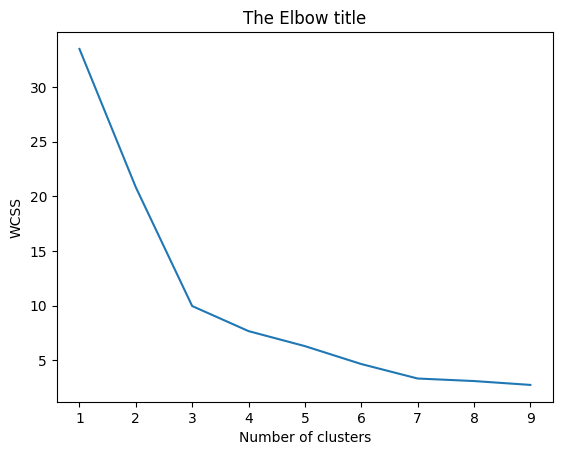

In [479]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10

for i in range(1, max_k):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(umap_embed_comments_array)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    number_clusters = range(1, max_k)

plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [480]:
#run kmeans with no. of clusters you see fit the most
k = 3
kmeans = KMeans(n_clusters = k, n_init='auto')
kmeans.fit(umap_embed_comments_array)
df['KMeans ID'] = kmeans.labels_

In [481]:
#merge all reviews of each cluster into one big sentence
df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])

for i in range(0, k):
    row = []
    row.append(i)
    row.append(df['comment'][df['KMeans ID'] == i].to_string())
    df_kmeans.loc[len(df_kmeans)] = row

In [482]:
df_kmeans

,KMeans ID,texts
0,0,2 จัดส่งรวดเร็วสินค้ามีคุณภาพดีกลิ่นติดทนร...
1,1,1 หอมมาก ติดทนมากกก ฉีด7.00 เลิกงาน 17.00 ...
2,2,0 ได้รับสินค้าแล้วค่ะทางร้านส่งเร็ว แพ็คมา...


In [483]:
#create regex compiler for removal of a character you don't want
special_characters = "/[!@#$%^&*']/g"
specialchar_pattern = re.compile(special_characters)

In [484]:
#create regex compiler for removal of any emoji
emoji_pattern = re.compile("["
u"\U0001F600-\U0001F64F" # emoticons
u"\U0001F300-\U0001F5FF" # symbols & pictographs
u"\U0001F680-\U0001F6FF" # transport & map symbols
u"\U0001F1E0-\U0001F1FF" # flags (iOS)
"]+", flags=re.UNICODE)

#create regex compiler for removal of digit
number_pattern = re.compile("[0-9]")
#create regex compiler for removal of white space
space_pattern = re.compile("\s+")
#create regex compiler for removal of .
dot_pattern = re.compile(r"\.+")
#create regex compiler for removal of \
backslash_pattern = re.compile(r"\\+")

In [485]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['',' ','    ','\n', '(', ')', '?', '+', '--', '//', 'ร้าน', '\u200b', 'ๆ(', '..', 'ๆๆๆๆ', 'ๆ', 'นะคะ', '-', '!', "['", "','","'", ',', '[']
screening_words = stopwords + removed_words

# words = new_words.union(thai_words())
# custom_dictionary_trie = Trie(words)

In [486]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
def tokenize_to_list(sentence):
    merged = []
    words = pythainlp.word_tokenize(str(sentence), engine='deepcut')

    for word in words:
        if word not in screening_words:
            merged.append(word)
    return merged

In [487]:
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x:collections.Counter(x).most_common())

9/9 [==============================] - 0s 26ms/step


In [488]:
df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,จัดส่งรวดเร็วสินค้ามีคุณภาพดีกลิ่นติดทนราคาดีร...,"[สินค้า, คุณภาพ, ดี, กลิ่น, ติด, ทน, ราคา, ดี,...","[(สินค้า, 4), (ดี, 4), (คุณภาพ, 1), (กลิ่น, 1)..."
1,1,หอมมากติดทนมากกกฉีดเลิกงานยังหอมหอมมากต้องลองก...,"[หอม, ติดทน, ก, กกฉีด, เลิก, งาน, หอมหอม, ลอง,...","[(กลิ่น, 6), (หอม, 5), (จาง, 3), (ติดทน, 2), (..."
2,2,ได้รับสินค้าแล้วค่ะทางร้านส่งเร็วแพ็คมาดีของมส...,"[สินค้า, ส่งเร็ว, แพ็คมา, ดี, มส่ง, ไว, ราคา, ...","[(ดี, 3), (สินค้า, 2), (ส่งเร็ว, 1), (แพ็คมา, ..."


In [489]:
# show top key word of each cluster

top_n_words = 10
for i in range(0, len(df_kmeans)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_n_words]}\n")

Cluster ID : 0

Most common words include : [('สินค้า', 4), ('ดี', 4), ('คุณภาพ', 1), ('กลิ่น', 1), ('ติด', 1), ('ทน', 1), ('ราคา', 1), ('ก', 1), ('กกรอ', 1), ('ห่อ', 1)]

Cluster ID : 1

Most common words include : [('กลิ่น', 6), ('หอม', 5), ('จาง', 3), ('ติดทน', 2), ('ก', 1), ('กกฉีด', 1), ('เลิก', 1), ('งาน', 1), ('หอมหอม', 1), ('ลอง', 1)]

Cluster ID : 2

Most common words include : [('ดี', 3), ('สินค้า', 2), ('ส่งเร็ว', 1), ('แพ็คมา', 1), ('มส่ง', 1), ('ไว', 1), ('ราคา', 1), ('ช้อปปี้ไลฟ์', 1), ('คุ้ม', 1), ('อยกลิ่น', 1)]



 ## cosine similarity clustering

In [490]:
#clustering using agglomorative clustering
knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(
linkage="average", connectivity=knn_graph, n_clusters=10, metric="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [491]:
#merge all reviews of each cluster into one big sentence
df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])
for i in range(0, k):
    row = []
    row.append(i)
    row.append(str(df['comment'][df['Agglomerative ID'] == i].tolist()))
    df_Agglomerative.loc[len(df_Agglomerative)] = row

In [492]:
#clean and tokenize sentences. count the occurences of each word
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x:
collections.Counter(x).most_common())

22/22 [==============================] - 1s 24ms/step


In [493]:
#show top keywords of each cluster
top_N_words = 10
for i in range(0, len(df_Agglomerative)):
    print(f"Cluster ID : {i}\n")
    print(f"Most common words include :{list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include :[('กลิ่น', 2), ('จาง', 2), ('ติด', 2), ('คน', 2), ('เรื่อง', 2), ('เปลี่ยนแพคเกจ', 1), ('อัพราคา', 1), ('รู้สึก', 1), ('แถม', 1), ('ทน', 1)]

Cluster ID : 1

Most common words include :[('กลิ่น', 6), ('หอม', 5), ('ดี', 4), ('สินค้า', 2), ('คุณภาพ', 2), ('ติด', 1), ('ทน', 1), ('ราคา', 1), ('package', 1), ('แข็งแรง', 1)]

Cluster ID : 2

Most common words include :[('กลิ่น', 9), ('ซื้อ', 5), ('ดี', 4), ('ขวด', 4), ('ราคา', 4), ('สินค้า', 3), ('หอม', 3), ('ตัว', 3), ('สั่ง', 3), ('ลด', 3)]



Cluster ID : 0
Group Name: "Longevity of Scent"

Cluster ID : 1
Group Name: "Product Quality and Fragrance"

Cluster ID : 2
Group Name: "Purchase Experience and Pricing"